In [1]:
#importing required libraries..
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test

In [2]:
#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values
                          
#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



c:\users\denisa\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: C:\Users\denisa/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

<ipython-input-4-c129967ba2f2>:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])


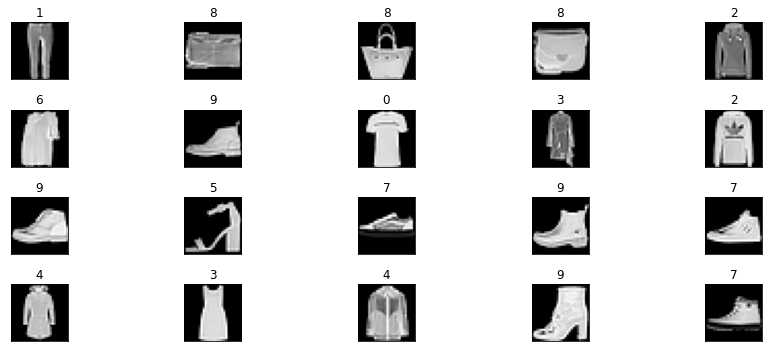

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120,10)
        #self.fc4 = nn.Linear(64,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        #not using dropout on output layer
        x = F.log_softmax(self.fc3(x), dim=1)
        return x   


In [6]:
model = Classifier()
#defining the loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

valid_loss_min = np.Inf #using this high value to make sure the update the weight first time
epochs = 10
steps = 0
model.train() #prep model for training
train_losses, valid_losses = [],[]
for e in range(epochs):
    running_loss =0 
    valid_loss = 0
    # train the model #
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)

    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()*images.size(0)

    running_loss = running_loss/len(trainloader.sampler)
    valid_loss =  valid_loss/len(validloader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))
    if valid_loss <= valid_loss_min:
        print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss






Epoch: 1 	Training Loss: 2.000868 	Validation Loss: 1.519738
validation loss decreased(inf -->1.519738). Saving Model ...
Epoch: 2 	Training Loss: 1.200942 	Validation Loss: 0.998440
validation loss decreased(1.519738 -->0.998440). Saving Model ...
Epoch: 3 	Training Loss: 0.907966 	Validation Loss: 0.839274
validation loss decreased(0.998440 -->0.839274). Saving Model ...
Epoch: 4 	Training Loss: 0.796119 	Validation Loss: 0.759688
validation loss decreased(0.839274 -->0.759688). Saving Model ...
Epoch: 5 	Training Loss: 0.738257 	Validation Loss: 0.718319
validation loss decreased(0.759688 -->0.718319). Saving Model ...
Epoch: 6 	Training Loss: 0.698012 	Validation Loss: 0.680870
validation loss decreased(0.718319 -->0.680870). Saving Model ...
Epoch: 7 	Training Loss: 0.670512 	Validation Loss: 0.659085
validation loss decreased(0.680870 -->0.659085). Saving Model ...
Epoch: 8 	Training Loss: 0.646220 	Validation Loss: 0.635279
validation loss decreased(0.659085 -->0.635279). Saving

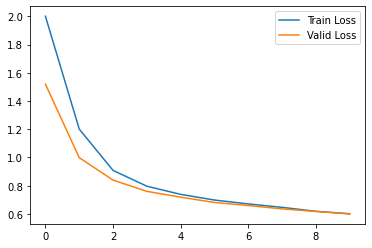

In [7]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [8]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [9]:
#track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in testloader:
    #forword pass 
    output = model(images)
    #calculate the loss
    loss = criterion(output, labels)
    #update the test loss
    test_loss += loss.item()*images.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    #compare predictions to the true labes
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    #calculate test accuracy for each object class
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
              (str(i), 100 * class_correct[i]/class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



Test Loss: 0.564168

Test Accuracy of     0: 78% (784/1000)
Test Accuracy of     1: 93% (939/1000)
Test Accuracy of     2: 67% (674/1000)
Test Accuracy of     3: 84% (847/1000)
Test Accuracy of     4: 80% (803/1000)
Test Accuracy of     5: 84% (848/1000)
Test Accuracy of     6: 27% (278/1000)
Test Accuracy of     7: 87% (877/1000)
Test Accuracy of     8: 92% (922/1000)
Test Accuracy of     9: 92% (922/1000)

Test Accuracy (Overall): 78% (7894/10000)


<ipython-input-10-897d1f24f526>:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


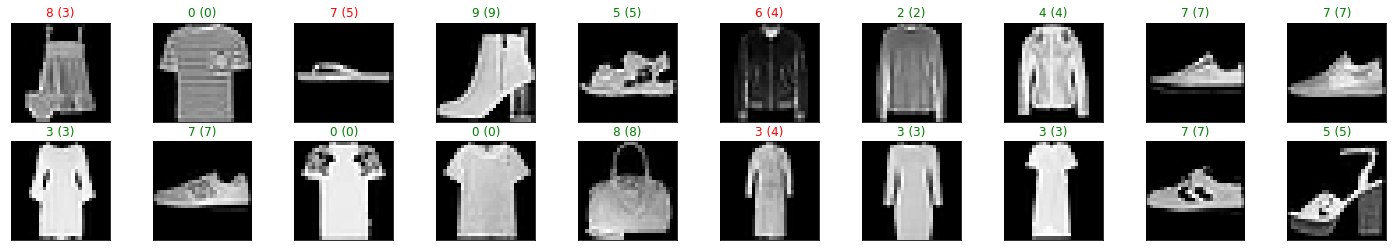

In [10]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))